In [101]:
import os

from skimage import io, transform

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils

import math
import matplotlib.pyplot as plt

import random


In [102]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device}")

Using cuda


In [103]:
IMAGE_SIZE = 180
IMAGE_CHANNELS = 3

Set the random seed:

In [104]:
torch.manual_seed(1337)

# Preparing training data

In [105]:
class VetleDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, sample_count, image_dir, transform=None):
        """
        Arguments:
            sample_count (int): How many samples
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sample_count = sample_count
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return self.sample_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        frameno = str(idx+1).zfill(4)
        filename = "frame" + frameno + ".png"

        img_name = os.path.join(self.image_dir,
                                filename)
        image = torchvision.io.read_image(img_name)

        if self.transform:
            image = self.transform(image)

        # Return image with a label. We won't use it, but it seems like tensorflow expects it
        return [image,0]

In [106]:
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE)])

In [107]:
dataset = VetleDataset(635, "assets/frames/", transform=transform)

Plot training data:

/home/vetle/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/tmp/ipykernel_14477/3059659951.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


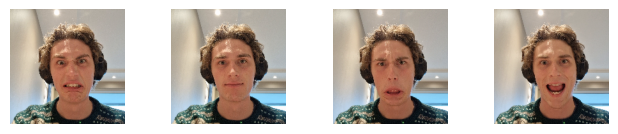

In [108]:
fig = plt.figure()
for plot_idx, dataset_idx  in enumerate(torch.randint(len(dataset), (4,))):
    sub = plt.subplot(1, 4, plot_idx+1)
    plt.tight_layout()
    sub.axis('off')
    image = dataset[dataset_idx.item()][0].permute(1,2,0)
    plt.imshow(image)
fig.show()


Create data loader:

In [109]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

# The models


## Discriminator

In [110]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(IMAGE_SIZE**2*IMAGE_CHANNELS, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), IMAGE_CHANNELS*IMAGE_SIZE**2)
        output = self.model(x)
        return output

In [111]:
discriminator = Discriminator()

## Generator

In [112]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNELS),
            nn.ReLU(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)

        return output



In [113]:
generator = Generator()

# Training


## Hyperparameters

In [114]:
lr = 0.001
num_epochs = 50
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Loop

In [115]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((real_samples.shape[0], 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))
        real_labels = torch.ones((batch_size, 1))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

KeyboardInterrupt: 

# Results

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


/tmp/ipykernel_14477/409940575.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


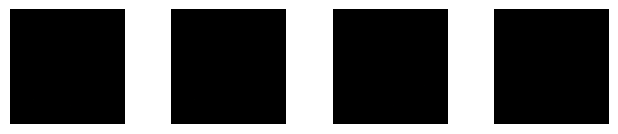

In [116]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
fig = plt.figure()
print(generated_samples[0])
for plot_idx, dataset_idx  in enumerate(torch.randint(len(generated_samples), (4,))):
    sub = plt.subplot(1, 4, plot_idx+1)
    plt.tight_layout()
    sub.axis('off')
    image = generated_samples[dataset_idx.item()].permute(1,2,0)
    plt.imshow(image)
fig.show()
